In [2]:
import gym
import tensorflow as tf
from keras.layers import Dense, Input, Concatenate
import numpy as np
import matplotlib.pyplot as plt

In [43]:
env = gym.make("Pendulum-v1")

state_size = env.observation_space.shape[0]
print("Size of State Space -> {}".format(state_size))
action_size = env.action_space.shape[0]
print("Size of Action Space -> {}".format(action_size))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action -> {}".format(upper_bound))
print("Min Value of Action -> {}".format(lower_bound))

Size of State Space -> 3
Size of Action Space -> 1
Max Value of Action -> 2.0
Min Value of Action -> -2.0


In [44]:
class OUActionNoise:
  def __init__(self, mean, std_dev, theta=0.15, dt=1e-2, x_initial=None):
    self.theta = theta
    self.mean = mean
    self.std_dev = std_dev
    self.dt = dt
    self.x_initial = x_initial
    self.reset()

  def __call__(self):
    x = (
        self.x_prev
         + self.theta * (self.mean - self.x_prev) * self.dt
         + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
    )
    self.x_prev = x
    return x

  def reset(self):
    if self.x_initial is not None:
      self.x_prev = self.x_initial
    else:
      self.x_prev = np.zeros_like(self.mean)

In [45]:
class Buffer:
  def __init__(self, buffer_capacity = 100000, batch_size=64):
    self.buffer_capacity = buffer_capacity  # Number of experiences to store at max
    self.batch_size = batch_size            # Number of tuples to train on
    self.buffer_counter = 0                 # Number of times record() was called

    self.state_buffer = np.zeros((self.buffer_capacity, state_size))
    self.action_buffer = np.zeros((self.buffer_capacity, action_size))
    self.reward_buffer = np.zeros((self.buffer_capacity, 1))
    self.next_state_buffer = np.zeros((self.buffer_capacity, state_size))

  def record(self, obs_tuple):

    index = self.buffer_counter % self.buffer_capacity

    self.state_buffer[index] = obs_tuple[0]
    self.action_buffer[index] = obs_tuple[1]
    self.reward_buffer[index] = obs_tuple[2]
    self.next_state_buffer[index] = obs_tuple[3]

    self.buffer_counter += 1

  @tf.function
  def update(
      self, state_batch, action_batch, reward_batch, next_state_batch
  ):
    # Training and updating Actor & Critic networks
    with tf.GradientTape() as tape:
      target_actions = target_actor(next_state_batch, training=True)
      y = reward_batch + gamma * target_critic(
          [next_state_batch, target_actions], training=True
      )
      critic_value = critic_model([state_batch, action_batch], training=True)
      critic_loss = tf.reduce_mean(tf.math.square(y - critic_value))

    critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
    critic_optimizer.apply_gradients(
        zip(critic_grad, critic_model.trainable_variables)
    )

    with tf.GradientTape() as tape:
      actions = actor_model(state_batch, training=True)
      critic_value = critic_model([state_batch, actions], training=True)
      actor_loss = -tf.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
    actor_optimizer.apply_gradients(
        zip(actor_grad, actor_model.trainable_variables)
    )

  def learn(self):
    record_range = min(self.buffer_counter, self.buffer_capacity)
    batch_indices = np.random.choice(record_range, self.batch_size)

    state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
    action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
    reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
    reward_batch = tf.cast(reward_batch, dtype='float32')
    next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

    self.update(state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau):
  for (a, b) in zip(target_weights, weights):
    a.assign(b * tau + a * (1 - tau))

In [46]:
def get_actor():
  
  last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

  inputs = Input(shape=(state_size,))
  dense_1 = Dense(256, activation='relu')(inputs)
  dense_2 = Dense(256, activation='relu')(dense_1)
  outputs = Dense(1, activation='tanh', kernel_initializer=last_init)(dense_2)

  outputs = outputs * upper_bound
  model = tf.keras.Model(inputs, outputs)
  return model

def get_critic():

  state_input = Input(shape=(state_size,))
  state_dense = Dense(16, activation='relu')(state_input)
  state_out = Dense(32, activation='relu')(state_dense)

  action_input = Input(shape=(action_size,))
  action_out = Dense(32, activation='relu')(action_input)

  concat = Concatenate()([state_out, action_out])

  dense_1 = Dense(256, activation='relu')(concat)
  dense_2 = Dense(256, activation='relu')(dense_1)
  outputs = Dense(1)(dense_2)

  model = tf.keras.Model([state_input, action_input], outputs)
  return model

In [47]:
def policy(state, noise_object):
  sampled_actions = tf.squeeze(actor_model(state))
  noise = noise_object()
  # Adding noise to action
  sampled_actions = sampled_actions.numpy() + noise
  
  # Make sure action is within bounds
  legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

  return [np.squeeze(legal_action)]

In [50]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_dev=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
gamma = 0.99
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -1506.0816862252352
Episode * 1 * Avg Reward is ==> -1490.2568369411615
Episode * 2 * Avg Reward is ==> -1533.0610744471471
Episode * 3 * Avg Reward is ==> -1430.5721657980287
Episode * 4 * Avg Reward is ==> -1448.5674249454341
Episode * 5 * Avg Reward is ==> -1422.848169967385
Episode * 6 * Avg Reward is ==> -1419.1121947792708
Episode * 7 * Avg Reward is ==> -1425.9260377751184
Episode * 8 * Avg Reward is ==> -1436.6243668569468
Episode * 9 * Avg Reward is ==> -1439.8665817726353
Episode * 10 * Avg Reward is ==> -1426.0050046633428
Episode * 11 * Avg Reward is ==> -1407.968710331621
Episode * 12 * Avg Reward is ==> -1403.7904163067276
Episode * 13 * Avg Reward is ==> -1341.1477933703736
Episode * 14 * Avg Reward is ==> -1305.235326373159
Episode * 15 * Avg Reward is ==> -1240.0874536714803
Episode * 16 * Avg Reward is ==> -1182.357695172885
Episode * 17 * Avg Reward is ==> -1139.2262028265511
Episode * 18 * Avg Reward is ==> -1113.533005104955
Episode 

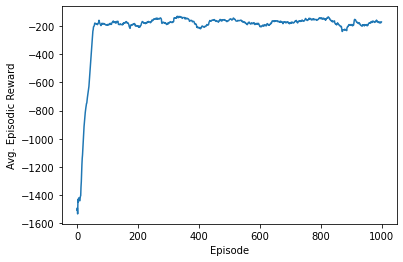

In [51]:
ep_reward_list = []
avg_reward_list = []

for ep in range(total_episodes):

  prev_state = env.reset()
  episodic_reward = 0

  while True:
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
    action = policy(tf_prev_state, ou_noise)
    state, reward, done, info = env.step(action)
    
    buffer.record((prev_state, action, reward, state))
    episodic_reward += reward

    buffer.learn()
    update_target(target_actor.variables, actor_model.variables, tau)
    update_target(target_critic.variables, critic_model.variables, tau)

    if done:
      break

    prev_state = state
  
  ep_reward_list.append(episodic_reward)

  avg_reward = np.mean(ep_reward_list[-40:])
  print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
  avg_reward_list.append(avg_reward)

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

In [52]:
# save the weights
actor_model.save_weights("models/pendulum_actor.h5")
critic_model.save_weights("models/pendulum_critic.h5")

target_actor.save_weights("models/pendulum_target_actor.h5")
target_critic.save_weights("models/pendulum_target_critic.h5")